<a href="https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG (Retrieval Augmented Generation)


Based on Shaw Talebi article: https://towardsdatascience.com/how-to-improve-llms-with-rag-abdc132f76ac


In [ ]:
#@title Execute this block to start importing the libraries (**llama_index**) and helper functions

# Download the documents
!mkdir data
!wget https://www.budget.gov.hk/2024/eng/pdf/e_budget_speech_2024-25.pdf
!mv e_budget_speech_2024-25.pdf data


!pip install -q llama-index
!pip install -q llama-index-embeddings-huggingface
!pip install -q auto-gptq
!pip install -q optimum
!pip install -q bitsandbytes

from transformers import AutoModelForCausalLM, AutoTokenizer
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings, SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor

# Wrap the output text
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)


# Show the LLM reply in the textarea box
import ipywidgets as widgets
display(HTML("<style>textarea, input { font-family: Courier New;}</style>"))


# Output the LLM reply only
def extractReply(output):
  delim = '[/INST]'
  return output[output.find(delim) + len(delim) + 1 : ]


def displayLLMOutput(llmOutput):
  text = widgets.Textarea(
      value=extractReply(llmOutput),
      description='LLM Reply:',
      disabled=False,
      layout=widgets.Layout(height="200px", width="auto"),

  )

  display(text)

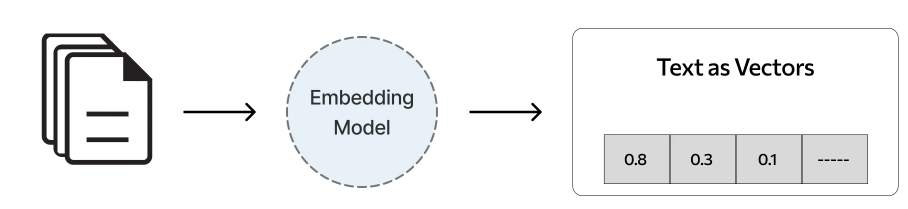

In [ ]:
#@title Import an embedding model from HuggingFace hub (https://huggingface.co/spaces/mteb/leaderboard)

embeddingModelName = "BAAI/bge-small-en-v1.5" # @param ["BAAI/bge-small-en-v1.5", "thenlper/gte-large"] {allow-input: true}
embeddingModel = HuggingFaceEmbedding(model_name=embeddingModelName)


In [ ]:
#@title Print the input embedding vector

query = "What's the new policies for the property stamp duty in the HK Financial Budget?" # @param {type:"string"}

embeddings = embeddingModel.get_text_embedding("What's the new policies for the property stamp duty in the HK Financial Budget?")
print("Vector size: {}".format(len(embeddings)))
print(embeddings)

In [ ]:
#@title Set the chunk size to read and store docs into Vector DB. Set up the search function

Settings.embed_model = embeddingModel
Settings.chunk_size = 256
Settings.chunk_overlap = 25
Settings.llm = None

# articles available here: {add GitHub repo}
documents = SimpleDirectoryReader("data").load_data()

# store docs into vector DB
index = VectorStoreIndex.from_documents(documents)

# set number of docs to retreive
top_k = 3

# configure retriever
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=top_k,
)

# assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.5)],
)

In [ ]:
#@title Look up relevant content from the embedding

query = "What's the new policies for the property stamp duty in the HK Financial Budget?" # @param {type:"string"}

# query the embedded documents
response = query_engine.query(query)

# reformat response
context = "Context:\n"
for i in range(top_k):
    context = context + response.source_nodes[i].text + "\n\n"

print(context)

In [ ]:
#@title Load the LLM (Large Language Model)

llmModel = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ" # @param ["TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"] {allow-input: true}

model_name = llmModel
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [ ]:
#@title Construct the prompt without the context and query LLM directly

query = "What's the new policies for the property stamp duty in the HK Financial Budget?" # @param {type:"string"}

# prompt (no context)
prompt = '[INST]\nPlease respond to the following question.\n{}\n[/INST]'.format(query)
print(prompt + '\n')

inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_new_tokens=280, pad_token_id=tokenizer.eos_token_id)

displayLLMOutput(tokenizer.batch_decode(outputs)[0])


In [ ]:
#@title Construct the prompt with the context and then query LLM

# query the embedded documents as the context
response = query_engine.query(query)

# reformat response
context = "Context:\n"
for i in range(top_k):
    context = context + response.source_nodes[i].text + "\n\n"


# prompt (with context)
prompt = '[INST]\n{}\n\nPlease respond to the following question. Use the context above if it is helpful.\n{}\n[/INST]'.format(context, query)
print(prompt + '\n\n')

inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_new_tokens=280, pad_token_id=tokenizer.eos_token_id)

displayLLMOutput(tokenizer.batch_decode(outputs)[0])